In [4]:
from matplotlib import pyplot as plt
import numpy as np
import importlib
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic

In [5]:
params = {
    "R" : 1.0,
    "Rz" : 0.01,
    "Bz" : 1.0,
    "eccentricity": 0.1,
    "energy": 1.0,
    "mass": 1.0,
    "sigma":0.4,
    "sigma_grid":0.5,
    "position_random_shift_percentage": 0.0/100,
    "epsilon":1.0,
    "planar": False,
    "zero_momentum": True
}T

e = params["eccentricity"]
params.update({
    "abc": np.array(
        [params["R"] / (1-e**2)**(1/4),
        params["R"] * (1-e**2)**(1/4),
        params["Rz"]]
    )
})
sim = SimulatorMagnetic(**params)
# sim = SimulatorLennard(**params)
r_init, v_init = sim.init_positions_velocities(**params)
print("N =", sim.particle_number())

In [7]:
history = sim.to_array(sim.simulate(1, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

100%|██████████| 99999/99999 [00:20<00:00, 4912.16it/s]


Text(0.5, 1.0, 'Z Angular Momentum')

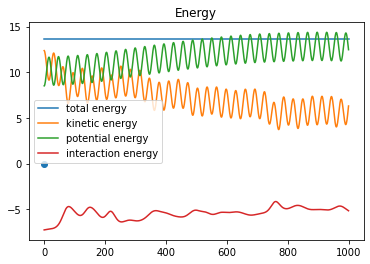

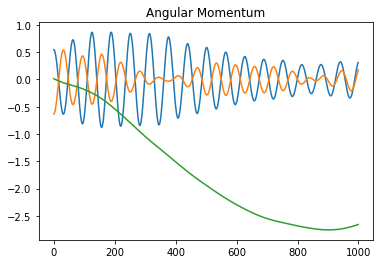

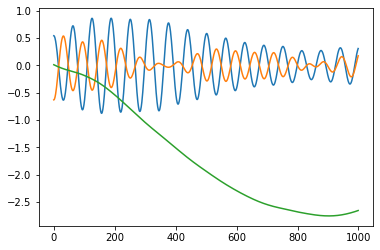

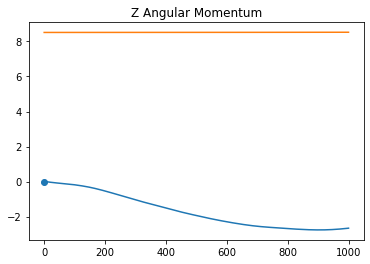

In [8]:
plt.figure()
plt.plot(np.sum(history["KE"] + history["PE"] + 0.5*history["IE"], axis=1), label="total energy")
plt.plot(np.sum(history["KE"], axis=1), label="kinetic energy")
plt.plot(np.sum(history["PE"], axis=1), label="potential energy")
plt.plot(0.5 * np.sum(history["IE"], axis=1), label="interaction energy")
plt.scatter(0,0)
plt.legend()
plt.title("Energy")

plt.figure()
plt.plot(np.sum(history["L"], axis=2))
plt.title("Angular Momentum")

plt.figure()
plt.plot(np.sum(history["L"], axis=2))

plt.figure()
plt.plot(np.sum(history["L"][:,2], axis=1))
plt.plot(np.sum(history["L"][:,2] + history["BInertia"], axis=1))
plt.scatter(0,0)
plt.title("Z Angular Momentum")


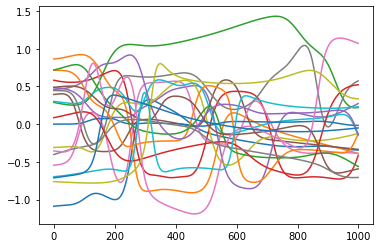

In [ ]:
plt.plot(history["L"][:,2,:]);

Text(0.5, 0, 'Z')

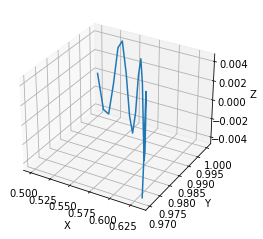

In [15]:
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")
pi = 20
rs = history["rs"]
ax.plot(rs[:,0,pi], rs[:,1,pi], rs[:,2,pi])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')